In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import my_graph_tools as mgt
import numpy as np
import tensorflow as tf
import h5py
import sonnet as snt
import matplotlib.pyplot as plt

from importlib import reload
from progressbar import progressbar

%matplotlib inline

pi = np.pi
twopi = np.pi*2

Useful reference on using Sonnet:  
https://github.com/deepmind/sonnet/blob/v2/examples/mlp_on_mnist.ipynb  
DeepMind graph nn example on physics system:  
https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/physics.ipynb#scrollTo=toCQhJIM93en  
graph_nets InteractionNetwork class:  
https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork

### Init global parameters

In [3]:
runname = "secondring_t1.0v1.0l10"
inputfname = "nn_inputs/"+runname+".hdf5"
h5in = h5py.File(inputfname,'r')
N_NODE_FEAT = 3
N_EDGE_FEAT = 6
N_NODE = h5in.attrs['n_nodes']
N_EDGE = h5in.attrs['n_edges']
NTG = h5in.attrs['nTG']
node_pos_np = h5in['node_coords'][:]
node_pos = mgt.get_node_coord_dict(h5in)
h5in.close()

In [4]:
# Add norm_stats to the h5 file if needed
h5f = h5py.File(inputfname,mode='a')
try:
    stats = h5f.attrs['node_norms']
    print("norm_stats already exists")
    node_norms = h5f.attrs['node_norms']
    edge_norms = h5f.attrs['edge_norms']
except:
    print("Adding norm stats...")
    node_norms, edge_norms = mgt.get_norm_stats(inputfname)
    h5f.attrs["node_norms"] = node_norms
    h5f.attrs["edge_norms"] = edge_norms
h5f.close()

norm_stats already exists


In [29]:
h5in = h5py.File(inputfname,'r')
h5g = mgt.snap2graph(h5in,day=1,tg=72,normalize=False)
h5g_tf = mgt.snap2graph(h5in,day=1,tg=72, use_tf=True)
h5in.close()

In [ ]:
col_lims = [-1., np.max(h5g.nodes[:,0])*0.5, -1., np.max(h5g.edges[:,0])*0.5]
# col_lims = [0, 1, 0, 1]
fig, ax = mgt.draw_graph(final_out_unnorm, node_pos, col_lims=col_lims)

In [119]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tout = sess.run({"out": m})

In [118]:
tf.reset_default_graph()
mlp = mymlp(2,2,5)
T = tf.random_uniform((20,1),maxval=10)
m = mlp(T)

In [24]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [30]:
geograph = geomlp(h5g_tf)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [31]:
geograph

GraphsTuple(nodes=<tf.Tensor 'GeoMLP_8_2/mlp/linear_0/add:0' shape=(446, 16) dtype=float64>, edges=<tf.Tensor 'GeoMLP_8_2/mlp_1/linear_0/add:0' shape=(4228, 32) dtype=float64>, receivers=array([141, 208, 140, ..., 444, 444, 445], dtype=int32), senders=array([  0,   0,   0, ...,  52,  42, 401], dtype=int32), globals=<tf.Tensor 'GeoMLP_8_2/mlp_2/linear_0/add:0' shape=(1, 8) dtype=float64>, n_node=array([446], dtype=int32), n_edge=array([4228], dtype=int32))

In [25]:
geomlp = mgt.GeoMLP(h5g)

In [ ]:
class global_MLP(snt.Module):
    def __init__(self,hiddensize,nlayer,outsize,name=None):
        self.net = snt.Sequential([
            snt.nets.MLP([hiddensize]*nlayer, activate_final=True),
            snnt.nets.MLP([outsize])
        ])
    def __call__(self,x):
        

In [117]:
class mymlp(snt.Module):
    def __init__(self,hiddensize,nlayer,outsize,name=None):
        self.net = snt.Sequential([
            snt.nets.MLP([hiddensize]*nlayer, activate_final=True),
            snt.nets.MLP([outsize])
        ])
    def __call__(self,x):
        return self.net(x)

In [34]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [35]:
tf.reset_default_graph()

h5in = h5py.File(inputfname,'r')
# edge_model_fn: a callable to perform per-edge computations, etc.
graphnet = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=N_EDGE_FEAT),
    node_model_fn=lambda: snt.Linear(output_size=N_NODE_FEAT),
    global_model_fn=lambda: mgt.timecrement(NTG),
    global_block_opt={"use_edges":False,"use_nodes":False})

input_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False)
output_graph = graphnet(input_graph)
lbl_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False)

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)
opt = tf.train.AdamOptimizer(learning_rate=1e-4)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3
Output globals size: 2


In [27]:
losses = []
sel_nodes_out, sel_nodes_input = [], []

nstep=10000
mydays_inp = [1,1,2,2]
mytgs_inp = [142,143,0,1]
mydays_lbl = [1,2,2,2]
mytgs_lbl = [143,0,1,2]
lbls, outputs = [], []
with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nstep)):
#             tg = i%NTG
#             day = (i//NTG)%7
#             lbltg = (i+1)%NTG
#             lblday = (day+((tg+1)//NTG))%7
            tg = mytgs_inp[i%4]
            day = mydays_inp[i%4]
            lbltg = mytgs_lbl[i%4]
            lblday = mydays_lbl[i%4]
            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
                "output": output_graph,
                "lbl_npy": lbl_graph,
                "train_vars": graphnet.trainable_variables
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if i%100==0:
                losses.append(train_dict['loss'])
            if i%500==0:
                outputs.append(train_dict['output'])
                lbls.append(train_dict['lbl_npy'])

100% (10000 of 10000) |##################| Elapsed Time: 0:01:18 Time:  0:01:18


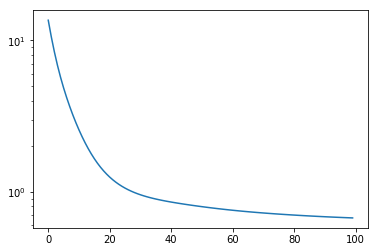

In [28]:
plt.semilogy(losses)

In [29]:
outputs_ = []
lbls_ = []
for g in outputs:
    outputs_.append(mgt.unnorm_graph(g,node_norms,edge_norms))
for l in lbls:
    lbls_.append(mgt.unnorm_graph(l,node_norms,edge_norms))
    
outputs = list(outputs_)
lbls = list(lbls_)
del outputs_, lbls_

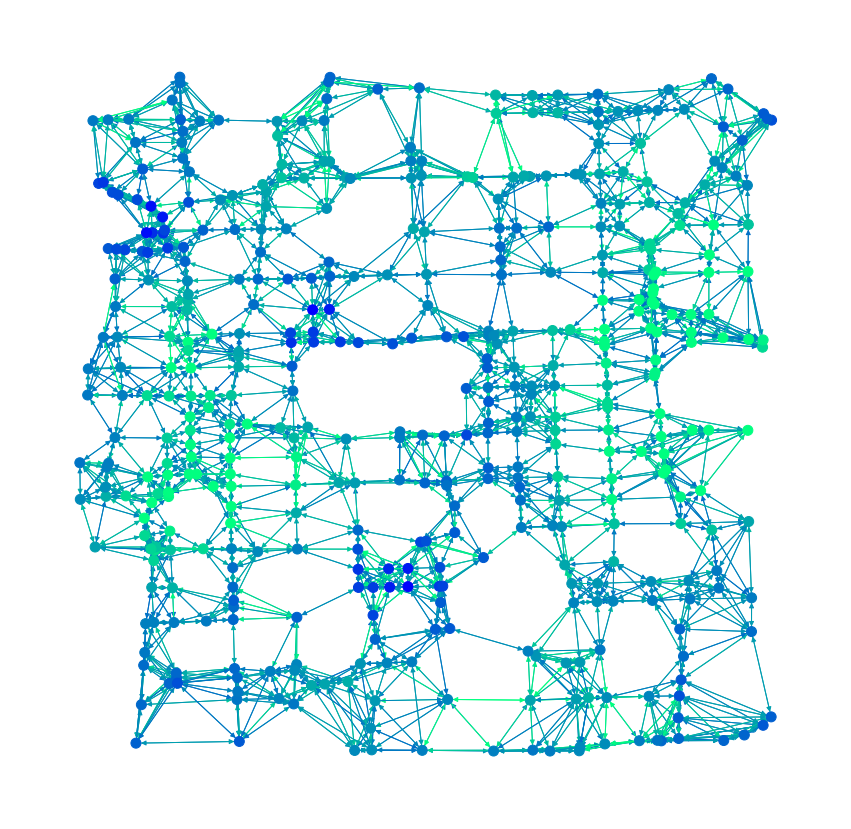

In [34]:
col_lims = [-1., node_norms[0,0]+node_norms[1,0], -1., edge_norms[0,0]+edge_norms[1,0]]
# col_lims = [0, 1, 0, 1]
fig, ax = mgt.draw_graph(outputs[-1], node_pos, col_lims=col_lims)

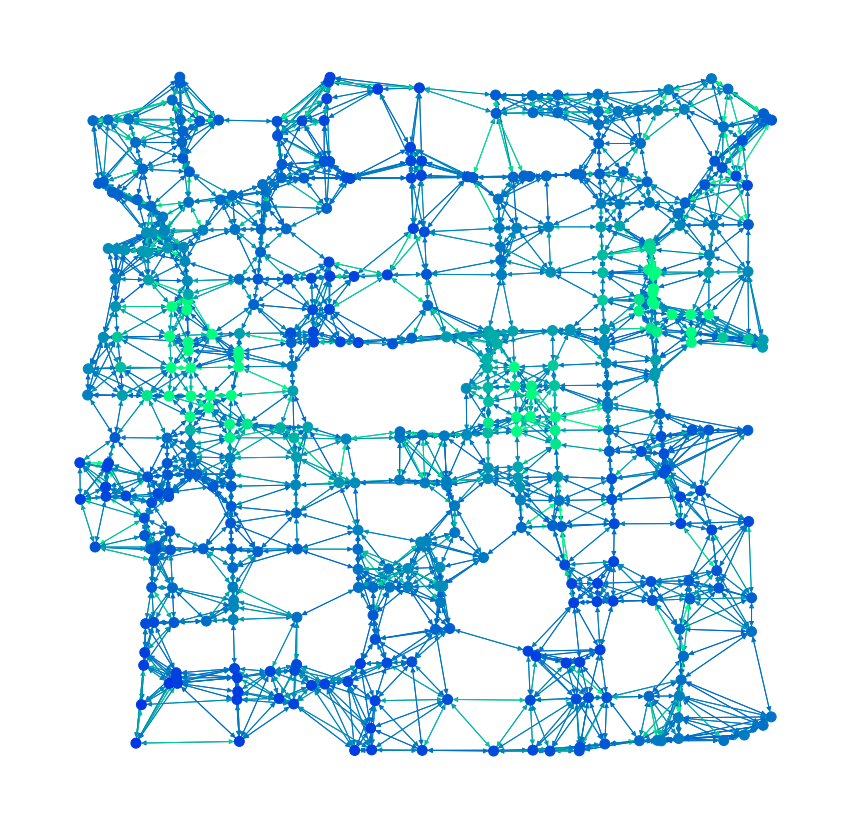

In [126]:
col_lims = [-1., node_norms[0,0]+node_norms[1,0], -1., edge_norms[0,0]+edge_norms[1,0]]
fig, ax = mgt.draw_graph(final_out, node_pos, col_lims=col_lims)

In [67]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [68]:
tf.reset_default_graph()
NUM_PROC_STEP = 3

h5in = h5py.File(inputfname,'r')
input_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="input")
graphnet = mgt.EncodeProcessDecode(edge_output_size=N_EDGE_FEAT,
               node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
output_graph_list = graphnet(input_graph,num_processing_steps=NUM_PROC_STEP)
output_graph = output_graph_list[-1]

lbl_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="label")

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)

opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
h5in.close()


GEO OUT
GraphsTuple(nodes=<tf.Tensor 'output_1/GeoMLP/mlp/linear_0/add:0' shape=(446, 5) dtype=float64>, edges=<tf.Tensor 'output_1/GeoMLP/mlp_1/linear_0/add:0' shape=(4228, 7) dtype=float64>, receivers=<tf.Tensor 'GeoMLP/data_dicts_to_graphs_tuple/add:0' shape=(4228,) dtype=int32>, senders=<tf.Tensor 'GeoMLP/data_dicts_to_graphs_tuple/add_1:0' shape=(4228,) dtype=int32>, globals=<tf.Tensor 'output_1/GeoMLP/mlp_2/linear_0/add:0' shape=(1, 9) dtype=float64>, n_node=<tf.Tensor 'GeoMLP/data_dicts_to_graphs_tuple/stack_2:0' shape=(1,) dtype=int32>, n_edge=<tf.Tensor 'GeoMLP/data_dicts_to_graphs_tuple/stack:0' shape=(1,) dtype=int32>)

Latent0
GraphsTuple(nodes=<tf.Tensor 'output_1/MLPGraphIndependent/graph_independent/node_model/sequential/mlp/Relu:0' shape=(446, 16) dtype=float64>, edges=<tf.Tensor 'output_1/MLPGraphIndependent/graph_independent/edge_model/sequential/mlp/Relu:0' shape=(4228, 16) dtype=float64>, receivers=<tf.Tensor 'GeoMLP/data_dicts_to_graphs_tuple/add:0' shape=(4228,) 

IncompatibleShapeError: MLPGraphNetwork/graph_network/edge_block/mlp/linear_0: Input shape must be [batch_size, 114] not: [batch_size, 123]

originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 79, in __init__
    global_block_opt={"use_edges":False,"use_nodes":False})
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/modules.py", line 282, in __init__
    edge_model_fn=edge_model_fn, **edge_block_opt)
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/blocks.py", line 415, in __init__
    self._edge_model = edge_model_fn()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 52, in make_mlp_model
    snt.nets.MLP([Lsize] * Nlayer, activate_final=True)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/nets/mlp.py", line 110, in __init__
    self._instantiate_layers()
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/nets/mlp.py", line 139, in _instantiate_layers
    for i in xrange(self._num_layers)]
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/nets/mlp.py", line 139, in <listcomp>
    for i in xrange(self._num_layers)]
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/basic.py", line 179, in __init__
    super(Linear, self).__init__(custom_getter=custom_getter, name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 79, in __init__
    global_block_opt={"use_edges":False,"use_nodes":False})
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/modules.py", line 282, in __init__
    edge_model_fn=edge_model_fn, **edge_block_opt)
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/blocks.py", line 415, in __init__
    self._edge_model = edge_model_fn()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 52, in make_mlp_model
    snt.nets.MLP([Lsize] * Nlayer, activate_final=True)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/nets/mlp.py", line 85, in __init__
    super(MLP, self).__init__(custom_getter=custom_getter, name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 79, in __init__
    global_block_opt={"use_edges":False,"use_nodes":False})
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/modules.py", line 282, in __init__
    edge_model_fn=edge_model_fn, **edge_block_opt)
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/blocks.py", line 415, in __init__
    self._edge_model = edge_model_fn()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 52, in make_mlp_model
    snt.nets.MLP([Lsize] * Nlayer, activate_final=True)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/sequential.py", line 65, in __init__
    super(Sequential, self).__init__(name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 79, in __init__
    global_block_opt={"use_edges":False,"use_nodes":False})
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/modules.py", line 282, in __init__
    edge_model_fn=edge_model_fn, **edge_block_opt)
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/blocks.py", line 403, in __init__
    super(EdgeBlock, self).__init__(name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 79, in __init__
    global_block_opt={"use_edges":False,"use_nodes":False})
  File "/usr/local/lib/python3.5/dist-packages/graph_nets/modules.py", line 275, in __init__
    super(GraphNetwork, self).__init__(name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 166, in __init__
    self._core = MLPGraphNetwork()
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 74, in __init__
    super(MLPGraphNetwork, self).__init__(name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


originally defined at:
  File "<ipython-input-68-457fbe85840c>", line 7, in <module>
    node_output_size=N_NODE_FEAT, init_graph=input_graph, name="output")
  File "/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py", line 152, in __init__
    super(EncodeProcessDecode, self).__init__(name=name)
  File "/usr/local/lib/python3.5/dist-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/template.py", line 161, in make_template
    **kwargs)


In [39]:
daytimes = np.zeros((7*NTG,2),dtype=int)
i = 0
for d in range(7):
    for tg in range(NTG):
        daytimes[i] = [d,tg]
        i+=1
np.random.shuffle(daytimes)

In [41]:
losses = []
out_graphs = []
nstep = 2000

mydays_inp = [1,1,2,2]
mytgs_inp = [142,143,0,1]
mydays_lbl = [1,2,2,2]
mytgs_lbl = [143,0,1,2]

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nstep)):
            if i%(7*NTG)==0:
                np.random.shuffle(daytimes)
#             tg = i%NTG
#             day = (i//NTG)%7
#             lbltg = (i+1)%NTG
#             lblday = (day+((tg+1)//NTG))%7
            daytime = daytimes[i%(7*NTG)]
            day = daytime[0]
            tg = daytime[1]
            lbltg = (tg+1)%NTG
            lblday = (day+1)%7 if (lbltg==0) else day
#             tg = mytgs_inp[i%4]
#             day = mydays_inp[i%4]
#             lbltg = mytgs_lbl[i%4]
#             lblday = mydays_lbl[i%4]
            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if (i%100==0) or (i==(nstep-1)):
                out_graph = sess.run([output_graph],
                                    feed_dict={
                                        input_graph: graph,
                                        lbl_graph: lbl
                                    })
                out_graphs.append(out_graph[-1])
                losses.append(train_dict['loss'])


100% (600 of 600) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


In [42]:
final_out = out_graphs[-1]
final_out = mgt.unnorm_graph(final_out, node_norms, edge_norms)
final_inp = mgt.unnorm_graph(graph,node_norms,edge_norms)
final_lbl = mgt.unnorm_graph(lbl,node_norms,edge_norms)

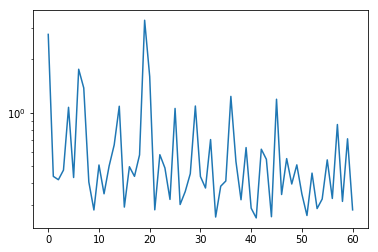

In [43]:
plt.semilogy(losses)

In [48]:
def make_set(h5_name):
    hf = h5py.File(h5_name,'r')
    ng = hf['node_features']
    ncars = np.zeros((7*mgt.NTG),dtype=np.int)
    daytimes = np.zeros((7*mgt.NTG,2),dtype=np.float)
    states = np.zeros((7*mgt.NTG,3),dtype=np.int)
    jamlist = np.arange(mgt.NTG//3-6,mgt.NTG//3+6)
    jamlist = np.append(jamlist,np.arange(2*mgt.NTG//3,2*mgt.NTG//3+12))
    i=0
    for d in progressbar(range(7)):
        for tg in progressbar(range(mgt.NTG)):
            nodes = ng["day"+str(d)+'tg'+str(tg)]
            ncars[i] = np.sum(nodes[:,0])
            daytimes[i] = [float(d)/6.,float(tg)/float(mgt.NTG-1)]
            if d in [0,6]:
                states[i,1] = 1
            elif tg in jamlist:
                states[i,2] = 1
            else:
                states[i,0] = 1
            i+=1
    hf.close()
    return daytimes, ncars, states
            

In [49]:
daytimes, ncars, states = make_set(inputfname)

100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [53]:
tf.reset_default_graph()

batchsize=36
mlp = snt.nets.MLP([16,16,3])
daytime_inp = tf.placeholder(np.double,shape=(batchsize,2))
daytime_lbl = tf.placeholder(np.double,shape=(batchsize,3))
lbl_arg = tf.arg_max(daytime_lbl,dimension=1)
logits = mlp(daytime_inp)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=lbl_arg,logits=logits))
# loss = tf.losses.mean_squared_error(labels=daytime_lbl,predictions=logits)
accuracy = tf.reduce_mean(tf.cast(tf.equal(lbl_arg,tf.arg_max(logits,dimension=1)),tf.float64))

opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
thelosses = []
thepreds = []
and_my_accs =  []
idxs = np.arange(len(daytimes))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in progressbar(range(8000)):
        np.random.shuffle(idxs)
        start = (i*batchsize)%NTG
        stop = start+batchsize
        grabs = idxs[start:stop]
        inp = daytimes[grabs]
        lbl = states[grabs]    
        
        train_dict = sess.run({
            "loss": loss,
            "_": loss_op,
            "logits": logits,
            "accuracy": accuracy,
        },     feed_dict={
            daytime_inp: inp,
            daytime_lbl: lbl
        })
        
        if i%100==0:
            and_my_accs.append(train_dict['accuracy'])
            thelosses.append(train_dict["loss"])
            thepreds.append(train_dict["logits"])


100% (12000 of 12000) |##################| Elapsed Time: 0:00:16 Time:  0:00:16
